In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import variance_scaling_initializer

import seaborn as sns
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#We use the recommended He normal initialization together with ReLU activation functions.
def weight_variable(name, shape):
    he_normal = variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False,
                                             seed=None, dtype=tf.float32) 
    return tf.get_variable(name, shape=shape, initializer=he_normal)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [4]:
#dataset
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

#parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 50
display_step = 100

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
x = tf.placeholder(tf.float32, [None, 784])
y_= tf.placeholder(tf.float32, [None, 10])
x_image = tf.reshape(x, [-1,28,28,1])

#layer 1
W_conv1 = weight_variable("W1", [5,5,1,32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#layer 2
W_conv2 = weight_variable("W2", [5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#layer 3
W_fc1 = weight_variable("W3", [7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#layer 5
W_fc2 = weight_variable("W5", [1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
#optimizers
train_step1 = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
train_step2 = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(cross_entropy)
train_step3 = tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)
train_step4 = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [8]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

Let's evaluate each optimizer one by one:

In [10]:
with tf.Session() as sess1:
    sess1.run(init)

    print("training with SGD optimizer...")
    avg_loss_sgd = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess1.run([train_step1, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_sgd[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with SGD optimizer...
Epoch 0000, training accuracy 0.12
Epoch 0100, training accuracy 0.76
Epoch 0200, training accuracy 0.74
Epoch 0300, training accuracy 0.78
Epoch 0400, training accuracy 0.88
Epoch 0500, training accuracy 0.92
Epoch 0600, training accuracy 0.84
Epoch 0700, training accuracy 0.86
Epoch 0800, training accuracy 0.84
Epoch 0900, training accuracy 0.90
test accuracy 0.9113


In [11]:
with tf.Session() as sess2:
    sess2.run(init)

    print("training with momentum optimizer...")
    avg_loss_momentum = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess2.run([train_step2, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_momentum[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


training with momentum optimizer...
Epoch 0000, training accuracy 0.26
Epoch 0100, training accuracy 0.90
Epoch 0200, training accuracy 0.92
Epoch 0300, training accuracy 1.00
Epoch 0400, training accuracy 0.98
Epoch 0500, training accuracy 0.90
Epoch 0600, training accuracy 0.96
Epoch 0700, training accuracy 0.96
Epoch 0800, training accuracy 0.96
Epoch 0900, training accuracy 0.94
test accuracy 0.9647


In [12]:
with tf.Session() as sess3:
    sess3.run(init)

    print("training with RMSProp optimizer...")
    avg_loss_rmsprop = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess3.run([train_step3, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_rmsprop[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with RMSProp optimizer...
Epoch 0000, training accuracy 0.08
Epoch 0100, training accuracy 0.96
Epoch 0200, training accuracy 1.00
Epoch 0300, training accuracy 1.00
Epoch 0400, training accuracy 1.00
Epoch 0500, training accuracy 1.00
Epoch 0600, training accuracy 1.00
Epoch 0700, training accuracy 1.00
Epoch 0800, training accuracy 1.00
Epoch 0900, training accuracy 1.00
test accuracy 0.9787


In [13]:
with tf.Session() as sess4:
    sess4.run(init)

    print("training with Adam optimizer...")
    avg_loss_adam = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess4.run([train_step4, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_adam[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with Adam optimizer...
Epoch 0000, training accuracy 0.14
Epoch 0100, training accuracy 0.94
Epoch 0200, training accuracy 0.96
Epoch 0300, training accuracy 1.00
Epoch 0400, training accuracy 1.00
Epoch 0500, training accuracy 1.00
Epoch 0600, training accuracy 1.00
Epoch 0700, training accuracy 0.98
Epoch 0800, training accuracy 1.00
Epoch 0900, training accuracy 0.98
test accuracy 0.9815


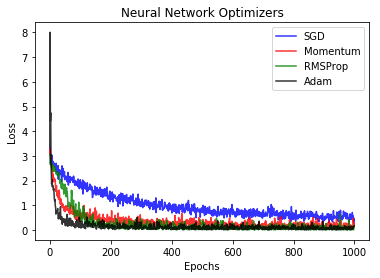

In [14]:
#We can visualize the loss for each optimizer below:
plt.figure()
plt.plot(avg_loss_sgd, color='blue', alpha=0.8, label='SGD')
plt.plot(avg_loss_momentum, color='red', alpha=0.8, label='Momentum')
plt.plot(avg_loss_rmsprop, color='green', alpha=0.8, label='RMSProp')
plt.plot(avg_loss_adam, color='black', alpha=0.8, label='Adam')
plt.title("Neural Network Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#As one can see easily, Adam gives the lowest loss values.